# Dataset

In [1]:
import os

file_names = os.listdir('./dataset/celeba_hq_256')
img_paths = ['./dataset/celeba_hq_256/' + file_name for file_name in file_names]
len(img_paths)

30000

In [2]:
import random

sample_size = int(len(img_paths) * 0.9)
train_imgpaths = random.sample(img_paths, sample_size)
val_imgpaths = [img_path for img_path in img_paths if img_path not in train_imgpaths]
train_imgpaths = img_paths[:100]
val_imgpaths = img_paths[100:150]

In [3]:
len(train_imgpaths), len(val_imgpaths)

(100, 50)

In [4]:
import numpy as np

def bbox2mask(img_shape, bbox, dtype='uint8'):
    """
    Generate mask in ndarray from bbox.
    bbox (tuple[int]): Configuration tuple, (top, left, height, width)\n
    With center value is 1, and the rest is 0.
    """

    height, width = img_shape[:2]

    mask = np.zeros((height, width, 1), dtype=dtype)
    mask[bbox[0]:bbox[0] + bbox[2], bbox[1]:bbox[1] + bbox[3], :] = 1

    return mask

In [5]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class InpaintingDataset(Dataset):
    def __init__(self, img_paths, image_size=[256, 256]):
        self.img_paths = img_paths
        self.tfs = transforms.Compose([
                transforms.Resize((image_size[0], image_size[1])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        self.image_size = image_size
        self.cached_samples = {}

    def __getitem__(self, index):
        img_path = self.img_paths[index]

        # Check if the sample is already cached
        if img_path in self.cached_samples:
            return self.cached_samples[img_path]

        # Process and cache the sample
        img = Image.open(img_path).convert("RGB")
        img = self.tfs(img)

        mask = self.get_mask()
        cond_image = img * (1.0 - mask) + mask * torch.randn_like(img)
        mask_img = img * (1.0 - mask) + mask

        sample = {
            "gt_image": img,
            "cond_image": cond_image,
            "mask": mask,
            "mask_image": mask_img,
            "path": img_path,
        }

        # Cache the processed sample
        self.cached_samples[img_path] = sample

        return sample

    def __len__(self):
        return len(self.img_paths)

    def get_mask(self):
        h, w = self.image_size
        mask = bbox2mask(self.image_size, (h // 4, w // 4, h // 2, w // 2))
        return torch.from_numpy(mask).permute(2, 0, 1)

In [6]:
train_dataset = InpaintingDataset(train_imgpaths)
val_dataset = InpaintingDataset(val_imgpaths)

In [7]:
sample = next(iter(train_dataset))

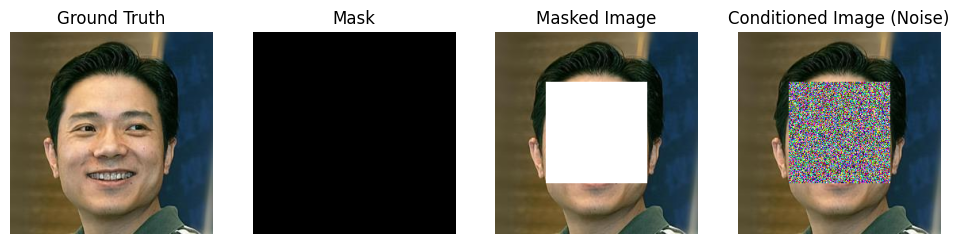

In [8]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Chuyển tensor về ảnh (range [0,1] để hiển thị)
def tensor_to_image(tensor):
    return F.to_pil_image((tensor.clamp(-1, 1) + 1) / 2)
  # Chuẩn hóa từ [-1,1] về [0,1]

gt_image = tensor_to_image(sample["gt_image"])       # Ảnh gốc
mask = tensor_to_image(sample["mask"])               # Mask
mask_img = tensor_to_image(sample["mask_image"])       # Ảnh bị che (1 tại vùng mask)
cond_image = tensor_to_image(sample["cond_image"])   # Ảnh có noise tại vùng mask

fig, axes = plt.subplots(1, 4, figsize=(12, 4))

axes[0].imshow(gt_image)
axes[0].set_title("Ground Truth")
axes[0].axis("off")

axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

axes[2].imshow(mask_img)
axes[2].set_title("Masked Image")
axes[2].axis("off")

axes[3].imshow(cond_image)
axes[3].set_title("Conditioned Image (Noise)")
axes[3].axis("off")

plt.show()

In [9]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, drop_last=False
)

In [10]:
len(train_loader)

3

# Training

In [11]:
from torchcfm.models.unet import UNetModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetModel(dim=(3, 256, 256), num_channels=32, num_res_blocks=1).to(device)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
n_epochs = 1000

from tqdm import tqdm
for epoch in range(n_epochs):
    losses = []
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()

        # x1 là ảnh gốc
        x1 = data["gt_image"].to(device)
        mask = data["mask"].to(device)

        # Tạo x0 là ảnh full noise
        x0 = torch.randn_like(x1).to(device)
        # x_noise giữ lại phần noise của x0 tại trung tâm, vùng rìa sẽ là ảnh gốc x1
        x_noise = x1 * (1.0 - mask) + mask * x0
        
        # Tạo t là thời gian random trong [0, 1), với kích thước (batch_size, 1, 1, 1) để nhân với ảnh x_noise
        t = torch.rand((x1.shape[0],1,1,1), device=device)

        # Tạo x_t là ảnh tại thời điểm t
        x_t = (1.0 - t) * x_noise + t * x1

        # Ảnh x_t này cũng phải giữ lại phần rìa là ảnh gốc x1, phần trung tâm là noise tại t
        # Có thể nói x_cond chính là x_t nhưng với phần rìa là ảnh gốc x1
        x_cond = mask * x_t + (1.0 - mask) * x1

        # v_gt là velocity ground truth
        v_gt = x1 - x_noise

        # squeeze t lại để có kích thước (batch_size,)
        t = t.squeeze()

        v_pred = model(t, x_cond)

        # phải nhân với mask để chỉ tính loss tại vùng mask
        loss = torch.mean(((v_pred - v_gt)**2)*mask)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    print(f"epoch: {epoch}, loss: {avg_loss:.4}")

In [13]:
sample['gt_image'].shape

torch.Size([3, 256, 256])

In [14]:
model.eval()
def euler_method(model, cond_image, t_steps, dt, mask):
    y = cond_image
    y_values = [y]

    for t in t_steps[1:]:
        with torch.no_grad():
            v_pred = model(t.to(device), y)
        y = y + dt * v_pred * mask
        y = (1.0 - mask)*cond_image + mask*y # Giữ lại phần không bị mask, phần mask có giá trị được cập nhật
        y_values.append(y)
    return torch.stack(y_values)

# Initial random image and class (optional)
sample = next(iter(train_loader))
gt_image = sample['gt_image'].to(device)
noise = torch.randn_like(gt_image, device=device)
mask = sample['mask'].to(device)
cond_image = gt_image*(1. - mask) + mask*noise
# or conde_image = sample['cond_image'].to(device)
# Time parameters
t_steps = torch.linspace(0, 1, 50, device=device)  # Two time steps from 0 to 1
dt = t_steps[1] - t_steps[0]  # Time step

# Solve the ODE using Euler method
traj = euler_method(model, cond_image, t_steps, dt, mask)

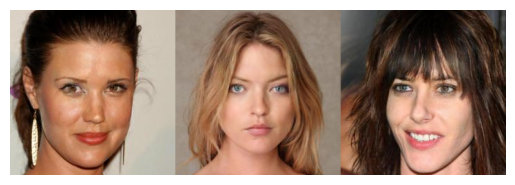

In [15]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

grid = make_grid(
    traj[-1, -3:].view([-1, 3, 256, 256]).clamp(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)

img = tensor_to_image(grid)
plt.axis("off")
plt.imshow(img)
plt.show()

In [16]:
traj.shape

torch.Size([50, 32, 3, 256, 256])

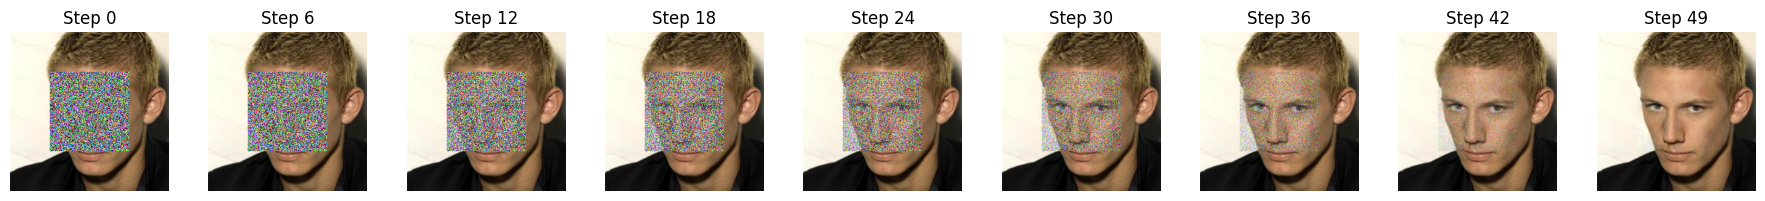

✅ Saved GIF to 'sample_22.gif'


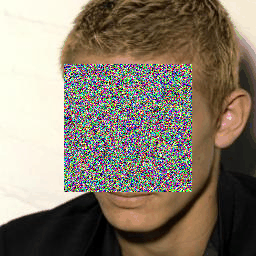

In [35]:
from IPython.display import display, Image as IPyImage

def show_and_save_sampling_progress(traj, sample_idx=0, num_steps=9, save_path="sampling.gif", duration=300):
    """
    Hiển thị quá trình sampling (dạng ảnh) và đồng thời lưu thành file GIF.

    Args:
        traj (Tensor): Tensor 5D (T, B, C, H, W)
        sample_idx (int): Index của sample trong batch
        num_steps (int): Số bước sampling để hiển thị và lưu gif
        save_path (str): Đường dẫn file gif muốn lưu
        duration (int): Thời gian mỗi frame (milliseconds)
    """
    T = traj.shape[0]
    assert num_steps <= T, "Số bước cần hiển thị phải nhỏ hơn hoặc bằng tổng số bước."

    # Lấy các bước cách đều từ 0 đến T-1
    indices = torch.linspace(0, T - 1, num_steps).long()

    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 2, 2))
    frames = []

    for i, idx in enumerate(indices):
        img_tensor = traj[idx, sample_idx]  # (C, H, W)
        pil_img = tensor_to_image(img_tensor.cpu())
        frames.append(pil_img)

        # Hiển thị bằng matplotlib
        axes[i].imshow(pil_img)
        axes[i].axis("off")
        axes[i].set_title(f"Step {idx.item()}")

    plt.tight_layout()
    plt.show()

    # Save GIF
    frames[0].save(
        save_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=0
    )
    print(f"✅ Saved GIF to '{save_path}'")

    display(IPyImage(filename=save_path))

sample_idx = 22
show_and_save_sampling_progress(traj, sample_idx=sample_idx, num_steps=9, save_path=f"sample_{sample_idx}.gif")

In [18]:
# Save Model
torch.save(model.state_dict(), "unet/unet_model.pth")